# Прогнозирование снижения активности клиентов интернет-магазина


К нам обратилась компания, владеющая интернет-магазином. Согласно внутреннему отчету было выявлено снижение активности покупателей. Так как большей части целевой аудитории уже известно о магазине - привлекать новых клиентов уже не так эффективно. Приоритетом бизнеса становится удержание текущих клиентов.

Компания предоставила нам данные о пользователях, использовании сайта, сумме покупок и общей выручке.
<br>От нас требуется 
1. разработать модель, предсказывающую снижение активности пользователя
2. предоставить рекомендации, способствующие улержанию пользователей

Выполним блоки с импортами необходимых библиотек и преднастройкой, и определим вспомогательные функции

In [1]:
!pip install shap 
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from phik import report
from phik.report import plot_correlation_matrix

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_STATE = 42
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
# Функция построения ящика с усами
def show_boxplot(data, title='', ylabel='', ax=None, show=True, get_ax=True):
    if ax is None:
        fig, ax = plt.subplots()

    data.plot(kind='box', ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_tick_params(labelbottom=False)
    
    if show:
        plt.show()

    if get_ax:
        return ax

In [4]:
# Функция построения гистограммы
def show_hist(data, bins=10, title='', xlabel='', ylabel='', ax=None, show=True, get_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    
    data.hist(bins=bins, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if show:
        plt.show()
    if get_ax:
        return ax

In [5]:
# Функция построения диаграммы-пирога и вывода таблицы по количеству и процентам
def show_pie(data, title, figsize=(4, 4)):
    count = data.value_counts()

    count.plot(kind='pie', figsize=figsize, autopct='%1.1f%%')
    plt.title(title)
    plt.ylabel('')
    plt.show()

    print(
        pd.DataFrame({
            'Количество': count,
            'Доля (%)': count / count.sum() * 100
        })
    )

## Загрузка данных

Загрузим предоставленные данные

### Общие данные о покупателе `market_file`

In [6]:
data_main = pd.read_csv('/datasets/market_file.csv')
data_main.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


Данные загрузились корректно, оценим общую информацию о датафрейме

In [7]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Представлена информация о 1300 пользователях, данные не содержат явных пропусков, колонки имеют верные типы данных.

Переименуем колонки

In [8]:
data_main.columns = ['id', 'purchaser_activity', 'service_type', 'allow_notify',
       'average_market_activ_6_m', 'market_activ_cur_m', 'duration_days',
       'promo_purchases_6_m_per', 'popular_category_6_m',
       'average_view_category_by_visit_cur_m',
       'count_unpaid_product_basket_3_m', 'count_crash_3_m',
       'average_view_page_by_visit_3_m']
data_main.head(1)

,id,purchaser_activity,service_type,allow_notify,average_market_activ_6_m,market_activ_cur_m,duration_days,promo_purchases_6_m_per,popular_category_6_m,average_view_category_by_visit_cur_m,count_unpaid_product_basket_3_m,count_crash_3_m,average_view_page_by_visit_3_m
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5


### Данные о выручке по покупателям (их тратам) `market_money`

In [9]:
data_money = pd.read_csv('/datasets/market_money.csv')
data_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"


Данные загрузились верно, сразу можно отметить, что колонка id не для уникального обозначения (на один id возможно несколько записей).

Оценим общую информацию о датафрейме

In [10]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Имеется 3900 записей, явных пропусков нет, типы данных - верные.

Переименуем колонки

In [11]:
data_money.columns = ['id', 'period', 'revenue']
data_money.head(1)

,id,period,revenue
0,215348,препредыдущий_месяц,0.00


### Данные о времени нахождения пользователя на сайте `market_time`

In [12]:
data_time = pd.read_csv('/datasets/market_time.csv')
data_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Все верно считалось. В этой таблице так же колонка id не с уникальными значениями.

Переименуем колонки и изучим информацию о данных

In [13]:
data_time.columns = ['id', 'period', 'minute']
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   period  2600 non-null   object
 2   minute  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропусков нет, типы верные

### Информация о среднемесячной прибыли за 3 месяца `money`

In [14]:
data_income = pd.read_csv('/datasets/money.csv')
data_income.head()

,id;Прибыль
215348;0,98.00
215349;4,16.00
215350;3,13.00
215351;4,87.00
215352;4,21.00


Чтения файла сбилось, нужно добавить форматирование сепараторов и разделителей для чисел

In [15]:
data_income = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
data_income.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Переименуем колонки и выведем общую информацию. По характеру данных - id будут уникальными

In [16]:
data_income.columns = ['id', 'income_3_m']
data_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1300 non-null   int64  
 1   income_3_m  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


- Данные загрузились корректно
- Количество строк совпадает с пользовательской таблицей, но подробнее проверим в следующих этапах
- Типы данных верные

### Итог загрузки данных

Мы загрузили информацию четырех файлов:
- Явных пропусков в данных нет
- Типы данных разметились корректно
- Колонка id  некоторых случаях является колонкой с уникальными значениями, в некоторых - нет
- Предпроложительно будем работать с данными о 1300 пользователях

## Предобработка данных

Произведем детальный анализ данных и их предобработку.

На этапе загрузки данных выяснили, что типы верные и отсутствуют явные пропуски. Остается проверить наличие дубликатов и корректность данных по каждой колонке

### Данные о покупателях

Начнем с самой объемной таблицы. Проверим наличие полных дубликатов

In [17]:
data_main.duplicated().sum()

0

Дубликатов не обнаружено - можем приступить к предобработке данных колонок.
<br>Предварительно вспомним их перечень

In [18]:
data_main.columns

Index(['id', 'purchaser_activity', 'service_type', 'allow_notify',
       'average_market_activ_6_m', 'market_activ_cur_m', 'duration_days',
       'promo_purchases_6_m_per', 'popular_category_6_m',
       'average_view_category_by_visit_cur_m',
       'count_unpaid_product_basket_3_m', 'count_crash_3_m',
       'average_view_page_by_visit_3_m'],
      dtype='object')

#### `id` - идентификатор покупателя

Колонка должна содержать уникальные значения - проверим это

In [19]:
data_main['id'].duplicated().sum()

0

Дубликатов среди значений нет - порядок

#### `purchaser_activity` - покупательская активность

Изучим, какие типы активности встречаются. По предоставленным данным должно быть 2 типа

In [20]:
data_main['purchaser_activity'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

Имеем 2 варианта активности, без дублирования/опечаток

#### `service_type` - уровень сервиса (подписка)

Знаем, что должно быть два варианта - проверим

In [21]:
data_main['service_type'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Есть опечатка - исправим ее

In [22]:
data_main['service_type'] = data_main['service_type'].apply(lambda x: 'стандарт' if x == 'стандартт' else x)
data_main['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

Теперь все корректно

#### `allow_notify` - разрешение о рассылках

По логике согласие либо есть, либо нет - проверим, какие данные хранятся в колонке

In [23]:
data_main['allow_notify'].unique()

array(['да', 'нет'], dtype=object)

Все четко и ясно, и корректно

#### `average_market_activ_6_m` - среднемесячное количество коммуникаций за 6 месяцев

Посмотрим общую информацию о данных

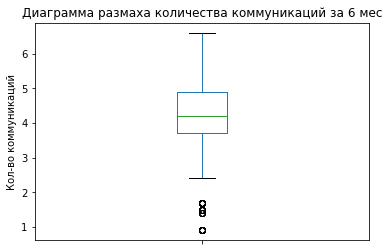

count   1,300.00
mean        4.25
std         1.01
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: average_market_activ_6_m, dtype: float64

In [24]:
show_boxplot(data_main['average_market_activ_6_m'], 'Диаграмма размаха количества коммуникаций за 6 мес', 'Кол-во коммуникаций')
data_main['average_market_activ_6_m'].describe()

По диаграмме видно выделяющиеся минимальные значения (менее 2-х), но эти значения вполоне реальны, поэтому оставим данные

#### `market_activ_cur_m` - количество коммуникаций за текущий месяц

Теперь изучим информацию о месячном количестве коммуникаций

In [25]:
data_main['market_activ_cur_m'].describe()

count   1,300.00
mean        4.01
std         0.70
min         3.00
25%         4.00
50%         4.00
75%         4.00
max         5.00
Name: market_activ_cur_m, dtype: float64

Количество коммуникация распределено между 3 и 5

#### `duration_days` - количество дней регистрации пользователя

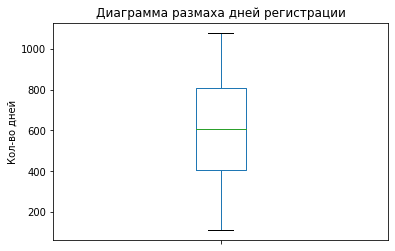

count   1,300.00
mean      601.90
std       249.86
min       110.00
25%       405.50
50%       606.00
75%       806.00
max     1,079.00
Name: duration_days, dtype: float64

In [26]:
show_boxplot(data_main['duration_days'], 'Диаграмма размаха дней регистрации', 'Кол-во дней')
data_main['duration_days'].describe()

В данных нет выдающихся значений: пользовательский стаж находится в диапазоне от 110 до 1079 дней (3 года)

#### `promo_purchases_6_m_per` - среднемесячная доля покупок по акции за 6 месяцев (%)

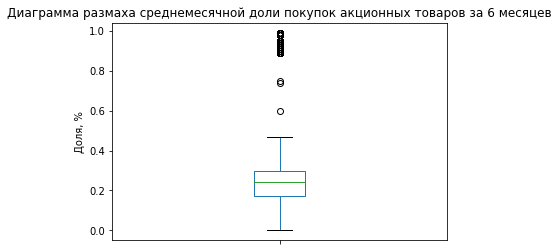

count   1,300.00
mean        0.32
std         0.25
min         0.00
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: promo_purchases_6_m_per, dtype: float64

In [27]:
show_boxplot(data_main['promo_purchases_6_m_per'], 
             'Диаграмма размаха среднемесячной доли покупок акционных товаров за 6 месяцев', 'Доля, %')
data_main['promo_purchases_6_m_per'].describe()

В целом значения в данной колонке корректны (значение доли от 0 до 1): в действительности возможно то, что покупатель будет совершать покупки только по акции - оставим данные на месте

#### `popular_category_6_m` - самая популярная категория товаров пользователя за 6 месяцев

Проверим данные на неявных дубликатов и ошибок

In [28]:
data_main['popular_category_6_m'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Варианты категорий товаров не содер ошибок

#### `average_view_category_by_visit_cur_m` - среднее количество категорий просматриваемых пользователем за визит в текущем месяце

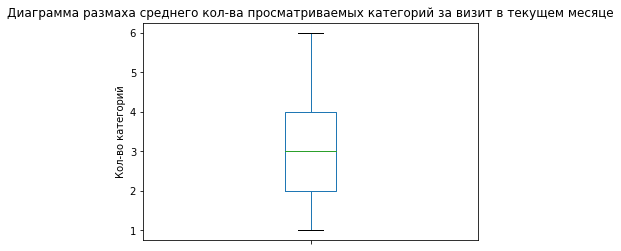

count   1,300.00
mean        3.27
std         1.36
min         1.00
25%         2.00
50%         3.00
75%         4.00
max         6.00
Name: average_view_category_by_visit_cur_m, dtype: float64

In [29]:
show_boxplot(data_main['average_view_category_by_visit_cur_m'], 
             'Диаграмма размаха среднего кол-ва просматриваемых категорий за визит в текущем месяце', 'Кол-во категорий')
data_main['average_view_category_by_visit_cur_m'].describe()

Данные не содержат аномалий. Количество категорий распределено в отрезке от 1 до 6 штук.

Значения выглядят корректно - предположительно на сервисе есть минимум 6 категорий, если судить по данным из колонки `popular_category_6_m`

#### `count_unpaid_product_basket_3_m` - число неоплаченных товаров в корзине за 3 месяца

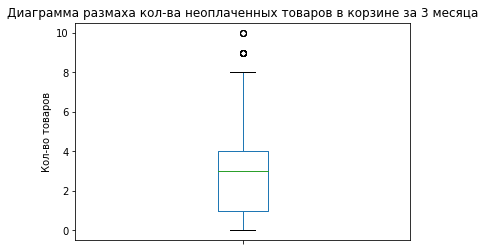

count   1,300.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: count_unpaid_product_basket_3_m, dtype: float64

In [30]:
show_boxplot(data_main['count_unpaid_product_basket_3_m'], 
             'Диаграмма размаха кол-ва неоплаченных товаров в корзине за 3 месяца', 'Кол-во товаров')
data_main['count_unpaid_product_basket_3_m'].describe()

Весь диапазон значений укладывается в рамки [0; 10] - что выглядит адекватными значениями.

Относительно всей статистики есть аномальные значения "забытых" товаров в корзине - более 8 позиций. Подсчитаем количество таких пользователей

In [31]:
len(data_main.query('count_unpaid_product_basket_3_m > 8'))

14

#### `count_crash_3_m` - количество сбоев, которые повлияли на пользователей за 3 месяца

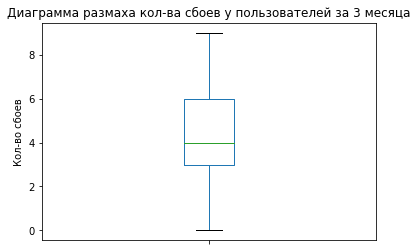

count   1,300.00
mean        4.19
std         1.96
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: count_crash_3_m, dtype: float64

In [32]:
show_boxplot(data_main['count_crash_3_m'], 
             'Диаграмма размаха кол-ва сбоев у пользователей за 3 месяца', 'Кол-во сбоев')
data_main['count_crash_3_m'].describe()

В данных нет "аномалий", диапазон значений корректный

#### `average_view_page_by_visit_3_m` - среднее количество страниц просмотренных за визит за 3 месяца

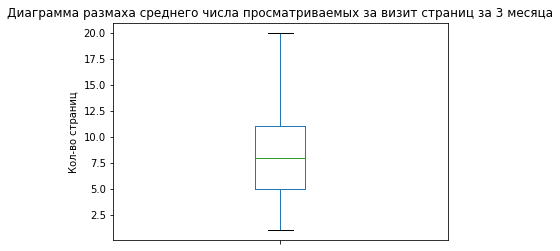

count   1,300.00
mean        8.18
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: average_view_page_by_visit_3_m, dtype: float64

In [33]:
show_boxplot(data_main['average_view_page_by_visit_3_m'], 
             'Диаграмма размаха среднего числа просматриваемых за визит страниц за 3 месяца', 'Кол-во страниц')
data_main['average_view_page_by_visit_3_m'].describe()

Аномалий не обнаружено, диапазон верный - как полагается минимум 1 страница посещается за визит

#### Подытог предобработки данных о пользователях

- Были устранены неявные дубликаты в колонке "уровень сервиса", вызванные опечаткой
- Все числовые данные содержат корректные диапазоны значений
- В некоторых колонках по диаграмме размаха встречаются "выбросы", однако они не являются нереальными данными или ошибочными значениями. Было принято их оставить

### Данные о выручке по покупателям (их тратам)

Проверим наличие дубликатов

In [34]:
data_money.duplicated().sum()

0

Дубликатов не обнаружено - можем приступим к предобработке данных, предварительно вспомнив их перечень

In [35]:
data_money.columns

Index(['id', 'period', 'revenue'], dtype='object')

#### `id` - идентификатор покупателя

В данной таблице колонка идентификаторов не обязана соджержать уникальные значения. Однако есть ограничение: эти id должны присутствовать в основной таблице, чтобы их можно было анализировать совместно.

Проверим, что все id этой колонки присутствуют в `data_main['id']` 

In [36]:
data_money['id'].isin(data_main['id']).sum() == len(data_money['id'])

True

Все встречающиеся `id` имеют связь с основной талицей

#### `period` - название периода, в который зафиксирована выручка

Изучим, какие значения встречаются в колонке

In [37]:
data_money['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Все значения уникальны, не содержат неявных дубликатов и пропусков.
<br>Исправим опечатку в слове предпредыдущий

In [38]:
data_money['period'] = data_money['period'].apply(lambda x: 'предпредыдущий_месяц' if x == 'препредыдущий_месяц' else x)
data_money['period'].unique()

array(['предпредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

#### `revenue` - сумма выручки (у.е.)

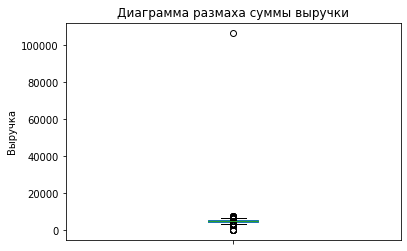

count     3,900.00
mean      5,025.70
std       1,777.70
min           0.00
25%       4,590.15
50%       4,957.50
75%       5,363.00
max     106,862.20
Name: revenue, dtype: float64

In [39]:
show_boxplot(data_money['revenue'],'Диаграмма размаха суммы выручки', 'Выручка')
data_money['revenue'].describe()

По диаграмме размаха встречается выбросы, но есть значение, превосходящее все остальные более чем в 10 раз - выглядит, как явная ошибка. Выведем данные со значениями более 20000 

In [40]:
data_money.query('revenue > 20000')

,id,period,revenue
98,215380,текущий_месяц,"106,862.20"


Данные с единственным значением. Получим id взглянем, какие данные по нему содержатся в таблице

In [41]:
strange_id = data_money.query('revenue > 20000')['id'].iloc[0]
data_money.query('id == @strange_id')

,id,period,revenue
96,215380,предпредыдущий_месяц,"5,051.00"
97,215380,предыдущий_месяц,"6,077.00"
98,215380,текущий_месяц,"106,862.20"


Явная ошибка в данных - заполним его средним значением на основе других периодов по пользователю

In [42]:
data_money.loc[98, 'revenue'] = data_money.loc[[96, 97], 'revenue'].mean()
data_money.query('id == @strange_id')

,id,period,revenue
96,215380,предпредыдущий_месяц,"5,051.00"
97,215380,предыдущий_месяц,"6,077.00"
98,215380,текущий_месяц,"5,564.00"


В одной аномалией разобрались, посмотрим, как изменится диаграмма размаха

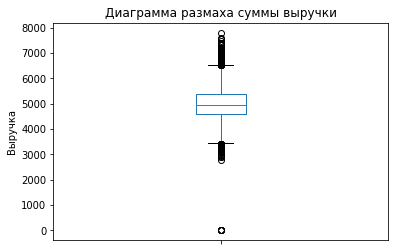

count   3,900.00
mean    4,999.72
std       706.97
min         0.00
25%     4,590.15
50%     4,957.50
75%     5,363.00
max     7,799.40
Name: revenue, dtype: float64

In [43]:
show_boxplot(data_money['revenue'],'Диаграмма размаха суммы выручки', 'Выручка')
data_money['revenue'].describe()

По прежнему встречаются выбивающиеся значения, однако все они идут достаточно кучно и лежат в разумных диапазонах значений.

Взглянем отдельно на минимальные значения

In [44]:
data_money.query('revenue < 1000')

,id,period,revenue
0,215348,предпредыдущий_месяц,0.00
2,215348,предыдущий_месяц,0.00
28,215357,предпредыдущий_месяц,0.00
29,215357,предыдущий_месяц,0.00
34,215359,предыдущий_месяц,0.00
35,215359,предпредыдущий_месяц,0.00


Есть 6 значений по 3 пользователям. Такие данные возможны для тех, кто недавно начал пользоваться сервисом или целенаправленно им не пользовался.

Посмотрим величину прибыли в текущем месяце

In [45]:
ids = data_money.query('revenue < 1000')['id'].unique()
data_money.query('id in @ids and period == "текущий_месяц"')

,id,period,revenue
1,215348,текущий_месяц,"3,293.10"
27,215357,текущий_месяц,"5,986.30"
33,215359,текущий_месяц,"4,735.00"


Эти три пользователя принесли прибыль в текущем месяце с разной интенсивностью.

Выбросы по диаграмме размаха оставим до последующего анализа. Выбросы не вызваны опечатками или нереальными значениями

#### Подытог предобработки данных о выручке по покупателям

- Встречающиеся идентификаторы соответствуют `id` из таблицы о данных покупателей 
- Исправили опечатку в значениях периода. Параметр не содержит неявных дубликатов
- Обнаружили аномальное значение в выручке, превышающее более чем в 10 раз остальные показатели. Заполнили его средним значением на основе данных о пользователе за другие месяца
- По диаграмме размаха суммы выручки обнаружены другие "выбросы" - их решено оставить до последующего анализа
    - Не содержат аномалий/опечаток
    - Находятся в диапазоне реально возможных значений
    - Значения выбросов расположены достаточно "кучно" на диаграмме

### Данные о времени нахождения пользователей на сайте

Проверим наличие дубликатов

In [46]:
data_time.duplicated().sum()

0

Дубликатов не обнаружено - можем приступим к предобработке данных, предварительно вспомнив их перечень

In [47]:
data_time.columns

Index(['id', 'period', 'minute'], dtype='object')

#### `id` - идентификатор покупателя

Как и с данными о выручке пользователей - дублирование id не проверяем (они валидны), проверяем их присутствовие в основной таблице

In [48]:
data_time['id'].isin(data_main['id']).sum() == len(data_time['id'])

True

Все корректно, все `id` встречаются в основной талице

#### `period` - название периода, в который зафиксировано время

Предположительно, значения этой колонки должны перекликаться с данными из таблице с выручкой, рассмотренной ранее.
<br>Посмотрим, какие значения встречаются

In [49]:
data_time['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В данном случае у нас только два периода. Исправим опечатку и проверим, что именования периода с двух таблиц совпадают

In [50]:
data_time['period'] = data_time['period'].apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)
data_time['period'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [51]:
data_time['period'].isin(data_money['period']).sum() == len(data_time['period'])

True

Опечатку исправили, наименования в обоих таблицах совпадают

#### `minute` - время, проведенное на сайте в минутах

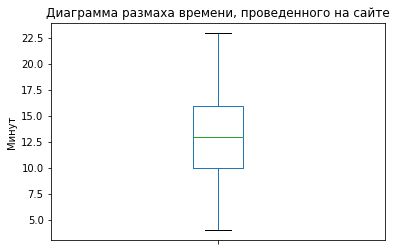

count   2,600.00
mean       13.34
std         4.08
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: minute, dtype: float64

In [52]:
show_boxplot(data_time['minute'], 'Диаграмма размаха времени, проведенного на сайте', 'Минут')
data_time['minute'].describe()

На сайте пользователи проводят от 4 до 23 минут за период. Диапазон значений корректный, выбросов нет

#### Подытог предобработки данных о проводимом времени на сайте

- Встречающиеся идентификаторы соответствуют `id` в данных о покупателях 
- Исправили опечатку в значениях периода. Проверили, что значения периода идентичны по напиманию со значениям периода в данных о выручке по пользователям
- Данные о времени не содержат аномальных и нереальных значений

### Данные о среднемесячной прибыли за 3 месяца

Проверим наличие дубликатов

In [53]:
data_income.duplicated().sum()

0

Дубликатов не обнаружено - можем приступим к предобработке данных, предварительно вспомнив их перечень

In [54]:
data_income.columns

Index(['id', 'income_3_m'], dtype='object')

#### `id` - идентификатор покупателя

Наложим два критерия на данные:
- id уникальны
- все id встречаются в `data_main['id']`

In [55]:
data_income['id'].duplicated().sum()

0

Дубликатов нет

In [56]:
data_income['id'].isin(data_main['id']).sum() == len(data_income['id'])

True

Все `id` присутствуют в основной таблице.
<br>Всё корректно

#### `income_3_m` - значение прибыли за 3 месяца (у.е.)

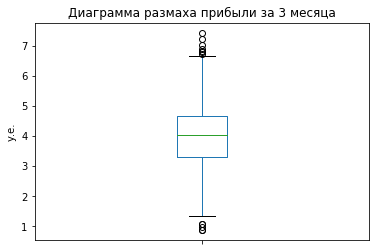

count   1,300.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: income_3_m, dtype: float64

In [57]:
show_boxplot(data_income['income_3_m'], 'Диаграмма размаха прибыли за 3 месяца', 'у.е.')
data_income['income_3_m'].describe()

Есть выбивающиеся значения:
- минимальные не являются отрицательными (корректный минимум)
- максимальные не сильно отстранены от верхней границы ящика и тоже выглядят корректными

Оставим выбросы до дальнейшего анализа

#### Подытог предобработки данных о среднемесячной прибыли

- Идентификаторы являются уникальными и совпадают со значениями идентификаторов данных `data_main`
- Значение прибыли содержат аномальные, но реально возможные значения. Их решено оставить

### Итог этапа предобработки данных

Рассмотрели все предоставленные данные

- Данные не содержат пропусков и дубликатов
- Были исправлены опечатки в категориальных данных
- Значения идентификаторов во всех датафреймах из идентичного набора значений
- Значения колонок `period` содержат одинаковое написание меток периода (два датафрейма)
- Все числовые данные содержат корректные и реальные диапазоны значений
- В некоторых данных присутствуют выбросы, которые решено оставить по причине их реальности:
    - `data_main`: колонки `average_market_activ_6_m`, `promo_purchases_6_m_per` `count_unpaid_product_basket_3_m`
    - `data_money`: колонка `revenue`
    - `data_income`: колонка `income_3_m`
    
Решение по аномальным значениям перечисленных колонок будет приниматься по месту при необходимости

## Исследовательский анализ данных

Отберем данные пользователей, у которых покупательская активность не менее трех месяцев - то есть только те, которые что-то покупали и приносили прибыль.

На этапе предобработки выяснили, что есть пользователи, по которым имеется нулевая выручка за некоторые периоды - отберем пользовательские `id` с нулевой выручкой по любому периоду в таблице `data_money`

In [58]:
ids = data_money.query('revenue == 0')['id'].unique()
ids

array([215348, 215357, 215359])

Исключим данные по этим пользователям из всех таблиц

In [59]:
shape_before = data_main.shape[0]
data_main = data_main[~data_main['id'].isin(ids)]
print(f'Датафрейм data_main: записей было {shape_before}, стало {data_main.shape[0]}')

shape_before = data_money.shape[0]
data_money = data_money[~data_money['id'].isin(ids)]
print(f'Датафрейм data_money: записей было {shape_before}, стало {data_money.shape[0]}')

shape_before = data_time.shape[0]
data_time = data_time[~data_time['id'].isin(ids)]
print(f'Датафрейм data_time: записей было {shape_before}, стало {data_time.shape[0]}')

shape_before = data_income.shape[0]
data_income = data_income[~data_income['id'].isin(ids)]
print(f'Датафрейм data_main: записей было {shape_before}, стало {data_income.shape[0]}')

Датафрейм data_main: записей было 1300, стало 1297
Датафрейм data_money: записей было 3900, стало 3891
Датафрейм data_time: записей было 2600, стало 2594
Датафрейм data_main: записей было 1300, стало 1297


Перейдем к исследованиям данных

### Данные о покупателях


#### Исследование покупательской активности

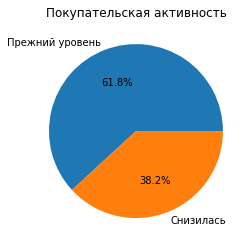

                 Количество  Доля (%)
Прежний уровень         802     61.84
Снизилась               495     38.16


In [60]:
show_pie(data_main['purchaser_activity'], 'Покупательская активность')

Все пользователи по покупательской активности делятся на 2 категории:
- прежний уровень активности - 61.8%
- активность снизилась - 38.2%

#### Исследование уровеня сервиса

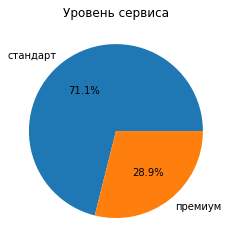

          Количество  Доля (%)
стандарт         922     71.09
премиум          375     28.91


In [61]:
show_pie(data_main['service_type'], 'Уровень сервиса')

По уровню сервиса выделяют:
- стандартный - 71.1%
- премиум - 28.9%

#### Исследование разрешения о рассылках

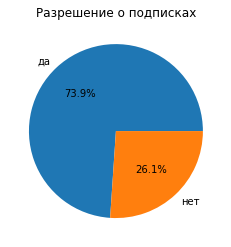

     Количество  Доля (%)
да          959     73.94
нет         338     26.06


In [62]:
show_pie(data_main['allow_notify'], 'Разрешение о подписках')

- большая часть пользователей согласилась на получение рассылок - 74%
- 26% отказались

#### Исследование среднемесячного количество коммуникаций за 6 месяцев

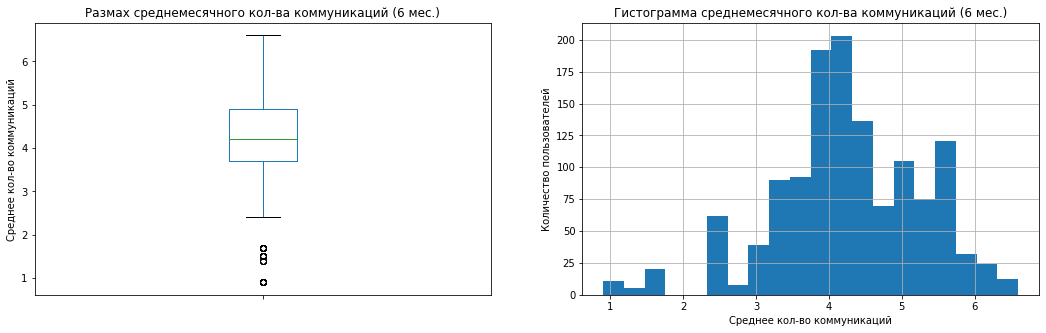

count   1,297.00
mean        4.25
std         1.02
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: average_market_activ_6_m, dtype: float64

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['average_market_activ_6_m'], 'Размах среднемесячного кол-ва коммуникаций (6 мес.)', 
             'Среднее кол-во коммуникаций', ax1, False)
show_hist(data_main['average_market_activ_6_m'], 20, 'Гистограмма среднемесячного кол-ва коммуникаций (6 мес.)', 
          'Среднее кол-во коммуникаций', 'Количество пользователей', ax2, False)
plt.show()

data_main['average_market_activ_6_m'].describe()

- Есть низкие показатели коммуникаций пользователей, принадлежащие диапазону 0-2
- В среднем пользователи за 6 месяцев получают 4.2 коммуникации, медианное значение немного выше - 4.3
- Минимальное значение составляет 0.9 коммуникаций, максимальное - 6.6

Рассмотрим пользователей с минимальным числом коммуникаций (менее 2-х)

In [64]:
less_activity = data_main.query('average_market_activ_6_m < 2')
print('Кол-во пользователей с минимальным числом коммуникаций (меньше 2-х):', len(less_activity))
less_activity

Кол-во пользователей с минимальным числом коммуникаций (меньше 2-х): 36


,id,purchaser_activity,service_type,allow_notify,average_market_activ_6_m,market_activ_cur_m,duration_days,promo_purchases_6_m_per,popular_category_6_m,average_view_category_by_visit_cur_m,count_unpaid_product_basket_3_m,count_crash_3_m,average_view_page_by_visit_3_m
30,215378,Снизилась,стандарт,да,1.70,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.70,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.50,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.50,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.70,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,Снизилась,премиум,да,1.40,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,Снизилась,стандарт,да,1.70,4,756,0.33,Товары для детей,2,3,7,4
70,215418,Снизилась,стандарт,нет,1.70,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,Снизилась,премиум,нет,0.90,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,Снизилась,стандарт,да,1.70,4,449,0.23,Косметика и аксесуары,3,4,4,5


- Таких пользователей 36 (~3%)
- У 34 из них пользователя снизилась покупательская активность
- В большинстве своем это пользователи, зарегистрированные более года
- Пользователи встречаются как с премиум сервисом, так и со стандартным

#### Исследование количества коммуникаций за текущий месяц

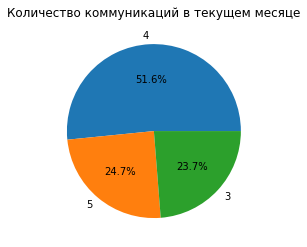

   Количество  Доля (%)
4         669     51.58
5         320     24.67
3         308     23.75


In [65]:
show_pie(data_main['market_activ_cur_m'], 'Количество коммуникаций в текущем месяце')

В текущем месяце пользователи получили:
- Преимущественно 4 коммуникации (51.6%)
- Оставшиеся пользователи поделились на две практическо равные группы
    - 3 коммуникации (23.7%)
    - 5 коммуникаций (24.7%)



#### Исследование количества дней со дня регистрации пользователя

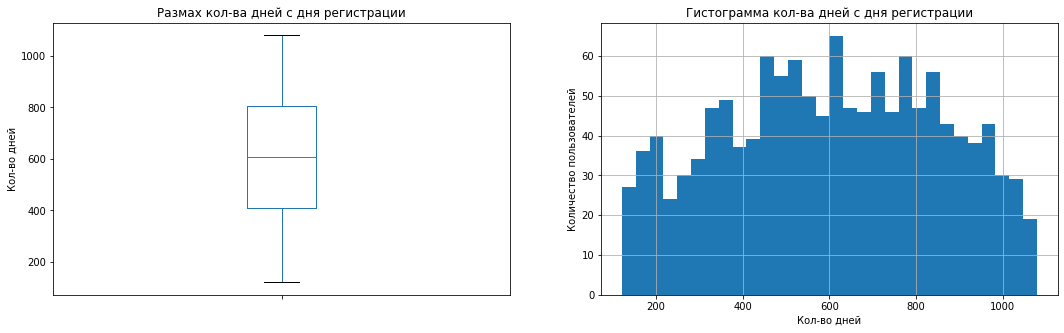

count   1,297.00
mean      602.99
std       249.10
min       121.00
25%       410.00
50%       607.00
75%       806.00
max     1,079.00
Name: duration_days, dtype: float64

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['duration_days'], 'Размах кол-ва дней с дня регистрации', 'Кол-во дней', ax1, False)
show_hist(data_main['duration_days'], 30, 'Гистограмма кол-ва дней с дня регистрации', 
          'Кол-во дней', 'Количество пользователей', ax2, False)
plt.show()

data_main['duration_days'].describe()

- Пользователи на сервисе по факту продолжительности регистрации распределены достаточно равномерно в диапазоне от 121 до 1079 дней (3 года)
- В среднем срок регистрации составляет 607 дней
- Половина пользователей относится к диапазону от 410 до 806 дней
- По гистограмме 
    - видно несколько диапазонов выдающихся значений (100-200, 300-400, 450-500) - возможно, это периоды рекламы сервиса, от которой регистрировалось больше пользователей, чем в окресстности
    - заметна тенденция на уменьшение регистраций новых пользователей (в направлении от 600 до 100)

#### Исследование среднемесячной доли покупок по акции за 6 месяцев (%)

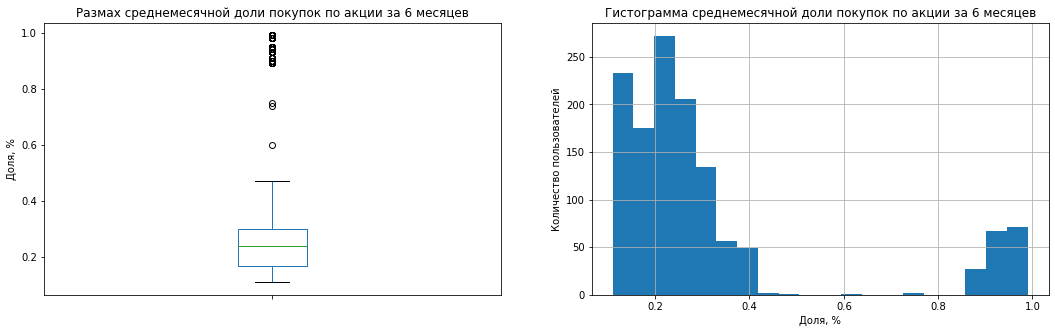

count   1,297.00
mean        0.32
std         0.25
min         0.11
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: promo_purchases_6_m_per, dtype: float64

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['promo_purchases_6_m_per'], 'Размах среднемесячной доли покупок по акции за 6 месяцев', 
             'Доля, %', ax1, False)
show_hist(data_main['promo_purchases_6_m_per'], 20, 'Гистограмма среднемесячной доли покупок по акции за 6 месяцев', 
          'Доля, %', 'Количество пользователей', ax2, False)
plt.show()

data_main['promo_purchases_6_m_per'].describe()

- 75% пользователей имеют долю акционный товаров до 30%
- Есть аномальные значения доли от 60 до 100%
- Минимально значение доли акционных товаров равна 11%
- В среднем у пользователей 24% акционных товаров

Посчитаем количество пользователей с долей более 0.5

In [68]:
print('Кол-во пользователей с долей более 0.5:', len(data_main.query('promo_purchases_6_m_per > 0.5')))

Кол-во пользователей с долей более 0.5: 168


#### Исследование популярной категории товаров у пользователей за 6 месяцев

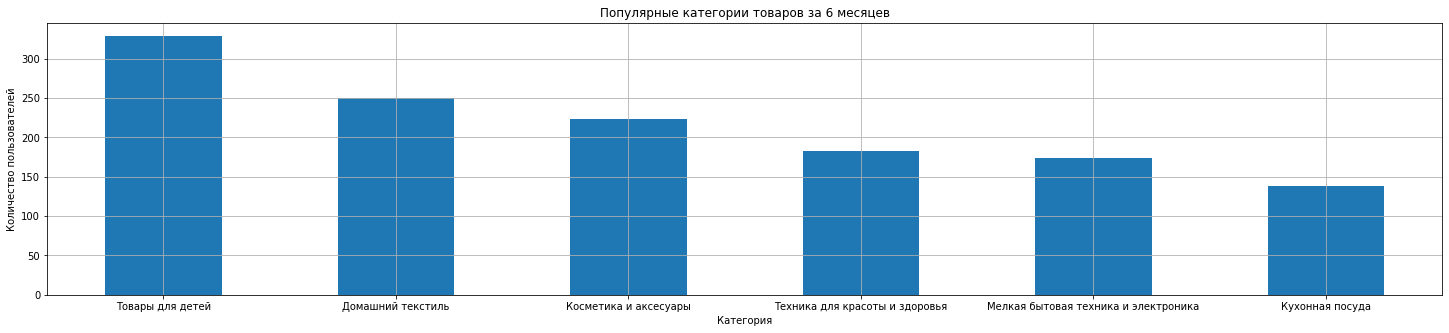

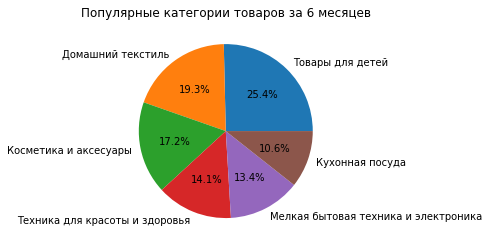

                                      Количество  Доля (%)
Товары для детей                             329     25.37
Домашний текстиль                            250     19.28
Косметика и аксесуары                        223     17.19
Техника для красоты и здоровья               183     14.11
Мелкая бытовая техника и электроника         174     13.42
Кухонная посуда                              138     10.64


In [69]:
data_main['popular_category_6_m'].value_counts().plot(kind='bar', figsize=(25, 5), grid=True)
plt.xticks(rotation=0)
plt.title('Популярные категории товаров за 6 месяцев')
plt.xlabel('Категория')
plt.ylabel('Количество пользователей')
plt.show()

show_pie(data_main['popular_category_6_m'], 'Популярные категории товаров за 6 месяцев')

По популярности категории распределены так:
- Самой популярной категорией является "Товары для детей" - четверть пользователей закупается преимущественно в ней (25.4%)
- Тройку лидеров замыкают
    - Домашний текстиль 19.3%
    - Косметика и аксесуары 17.2%
- Остальные категории увлекают менее половины пользователей (38.2%):
    - Техника для красоты и здоровья 14.1%
    - Мелкая бытовая техника и электроника 13.4%
    - Кухонная посуда 10.7%

#### Исследование среднего количество категорий, просматриваемых пользователем за визит в текущем месяце

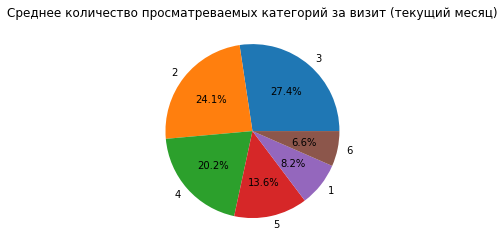

   Количество  Доля (%)
3         355     27.37
2         312     24.06
4         262     20.20
5         177     13.65
1         106      8.17
6          85      6.55


In [70]:
show_pie(data_main['average_view_category_by_visit_cur_m'], 
         'Среднее количество просматреваемых категорий за визит (текущий месяц)')

- Б**о**льшая часть пользователей просматривает от 2 до 4 категорий (71.7%)
    - две 24.1%
    - три 27.4%
    - четыре 20.2%
- Достаточно редко просматривают 6 категорий (6.6%) или 1 категорию (8.2%)
- Пять категорий в среднем рассматривают 13.7%

#### Исследование числа неоплаченных товаров в корзине за 3 месяца

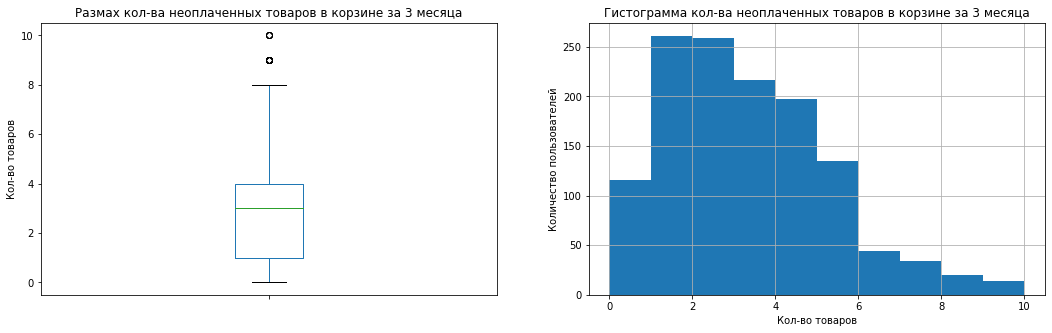

count   1,297.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: count_unpaid_product_basket_3_m, dtype: float64

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['count_unpaid_product_basket_3_m'], 'Размах кол-ва неоплаченных товаров в корзине за 3 месяца', 
             'Кол-во товаров', ax1, False)
show_hist(data_main['count_unpaid_product_basket_3_m'], 10, 'Гистограмма кол-ва неоплаченных товаров в корзине за 3 месяца', 
          'Кол-во товаров', 'Количество пользователей', ax2, False)
plt.show()

data_main['count_unpaid_product_basket_3_m'].describe()

- В среднем у пользователей 3 неоплаченных товара в корзине за 3 месяца
- Есть те, кто не оставляет товары в корзине (0)
- Есть пользователи с аномальными значениями товаров: от 8 до 10 штук
- 50% пользователей имеет от 1 до 4 неоплаченных товаров в корзине

Подсчитаем количество пользователей по каждому рубежу оставленных товаров

In [72]:
data_main['count_unpaid_product_basket_3_m'].value_counts()

1     261
2     259
3     217
4     197
5     135
0     116
6      44
7      34
8      20
9      10
10      4
Name: count_unpaid_product_basket_3_m, dtype: int64

- К аномальному диапазону 8-10 относится 34 пользователя

#### Исследование количества сбоев, которые повлияли на пользователей за 3 месяца

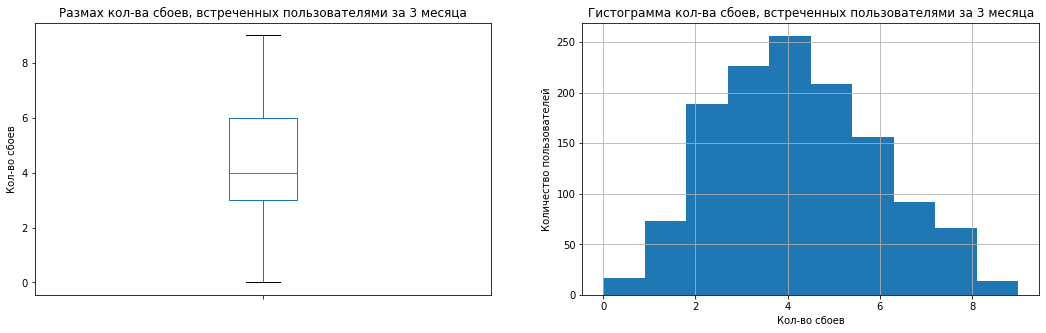

count   1,297.00
mean        4.18
std         1.95
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: count_crash_3_m, dtype: float64

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['count_crash_3_m'], 'Размах кол-ва сбоев, встреченных пользователями за 3 месяца', 
             'Кол-во сбоев', ax1, False)
show_hist(data_main['count_crash_3_m'], 10, 'Гистограмма кол-ва сбоев, встреченных пользователями за 3 месяца', 
          'Кол-во сбоев', 'Количество пользователей', ax2, False)
plt.show()

data_main['count_crash_3_m'].describe()

- 50% пользователей встречало от 3 до 6 сбоев за 3 месяца
- В среднем было 4 сбоя на пользователя
- Есть пользователи, которых не затронули сбои (0)
- Максимальное возможное число сбоев за 3 месяца - 9

#### Исследование среднего количества страниц просмотриваемых за визит за 3 месяца

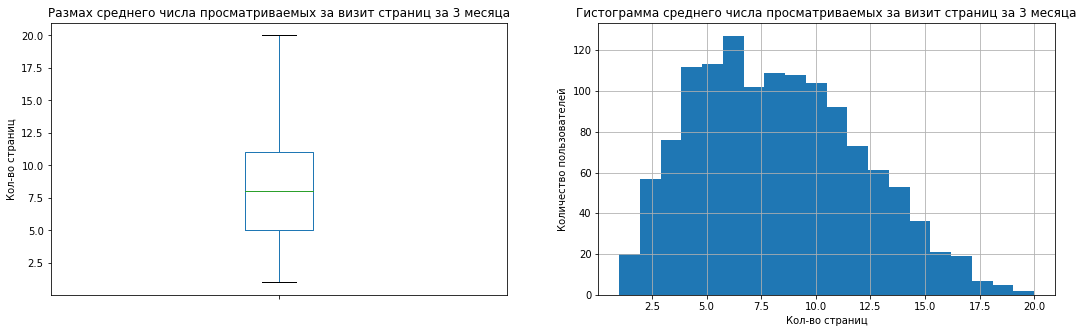

count   1,297.00
mean        8.19
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: average_view_page_by_visit_3_m, dtype: float64

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_main['average_view_page_by_visit_3_m'], 'Размах среднего числа просматриваемых за визит страниц за 3 месяца', 
             'Кол-во страниц', ax1, False)
show_hist(data_main['average_view_page_by_visit_3_m'], 20, 
          'Гистограмма среднего числа просматриваемых за визит страниц за 3 месяца', 
          'Кол-во страниц', 'Количество пользователей', ax2, False)
plt.show()

data_main['average_view_page_by_visit_3_m'].describe()

По данным за 3 месяца:
- В среднем пользователи просматривают 8 страницы за визит
- 50% пользователей просматривают от 5 до 11 страниц за визит
- Большой пласт пользователей просматривают от 11 до 20 страниц за визит
- Единицы просматривают от 17 до 20 страниц или от 1 до 2 страниц

### Данные о выручке по покупателям (их тратам)

#### Исследовани названий периода, в который зафиксирована выручка пользователя

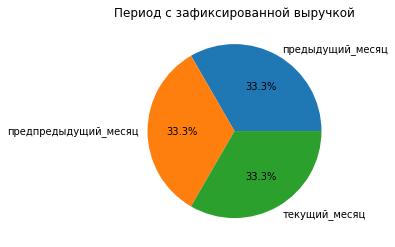

                      Количество  Доля (%)
предыдущий_месяц            1297     33.33
предпредыдущий_месяц        1297     33.33
текущий_месяц               1297     33.33


In [75]:
show_pie(data_money['period'], 'Период с зафиксированной выручкой')

Имеем три вида периода, данные по которым есть, видимо, для каждого пользователя - проверим это, подсчитав дубликаты в каждой категории

In [76]:
print('Количество дубликатов в группе "текущий месяц":',
      data_money[data_money['period'] == 'текущий_месяц']['id'].duplicated().sum())
print('Количество дубликатов в группе "предыдущий_месяц месяц":',
      data_money[data_money['period'] == 'предыдущий_месяц']['id'].duplicated().sum())
print('Количество дубликатов в группе "предыдущий_месяц месяц":',
      data_money[data_money['period'] == 'предпредыдущий_месяц']['id'].duplicated().sum())

Количество дубликатов в группе "текущий месяц": 0
Количество дубликатов в группе "предыдущий_месяц месяц": 0
Количество дубликатов в группе "предыдущий_месяц месяц": 0


Дубликатов нет, значит по каждому пользователю имеем три записи в датафрейме с разным периодом

#### Исследование суммы выручки (у.е.)

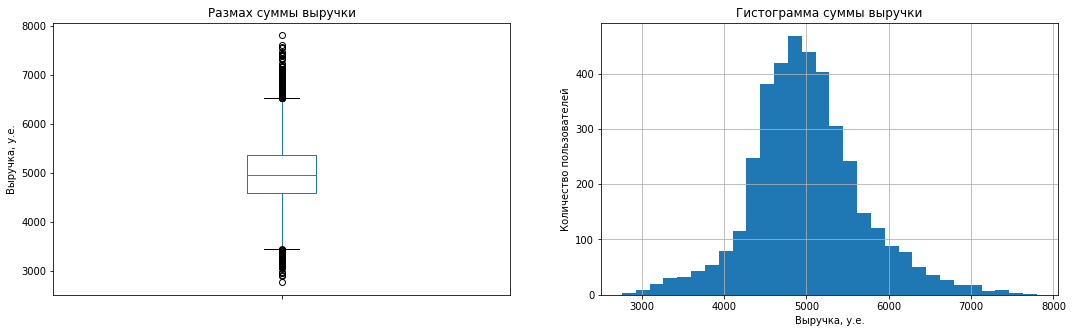

count   3,891.00
mean    5,007.68
std       679.21
min     2,758.70
25%     4,592.00
50%     4,959.00
75%     5,363.20
max     7,799.40
Name: revenue, dtype: float64

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_money['revenue'], 'Размах суммы выручки', 'Выручка, у.е.', ax1, False)
show_hist(data_money['revenue'], 30, 'Гистограмма суммы выручки', 'Выручка, у.е.', 'Количество пользователей', ax2, False)
plt.show()

data_money['revenue'].describe()

- Половина пользователей (50%) приносят от 4 592 до 7 799 у.е. выручки за период
- Среднее и медиана - 5 тысяч у.е.
- График гистограммы походит на нормальное распределение с длинными хвостами по краям, которые содержат наборы аномальных значений

### Данные о времени нахождения пользователей на сайте

#### Исследование названий периодов, в которые фиксировалось время

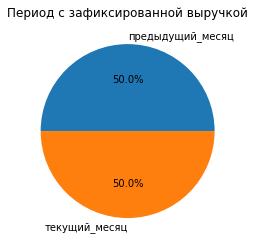

                  Количество  Доля (%)
предыдущий_месяц        1297     50.00
текущий_месяц           1297     50.00


In [78]:
show_pie(data_time['period'], 'Период с зафиксированной выручкой')

Информация о проводимом времени на сайте присутвтует только для двух периодов на каждого пользователя.
<br>Убедимся в этом - проверим, что в каждом периоде нет дубликатов по `id`

In [79]:
print('Количество дубликатов в группе "текущий месяц":',
      data_time[data_time['period'] == 'текущий_месяц']['id'].duplicated().sum())
print('Количество дубликатов в группе "предыдущий_месяц месяц":',
      data_time[data_time['period'] == 'предыдущий_месяц']['id'].duplicated().sum())

Количество дубликатов в группе "текущий месяц": 0
Количество дубликатов в группе "предыдущий_месяц месяц": 0


#### Исследование времени, проведенного на сайте в минутах

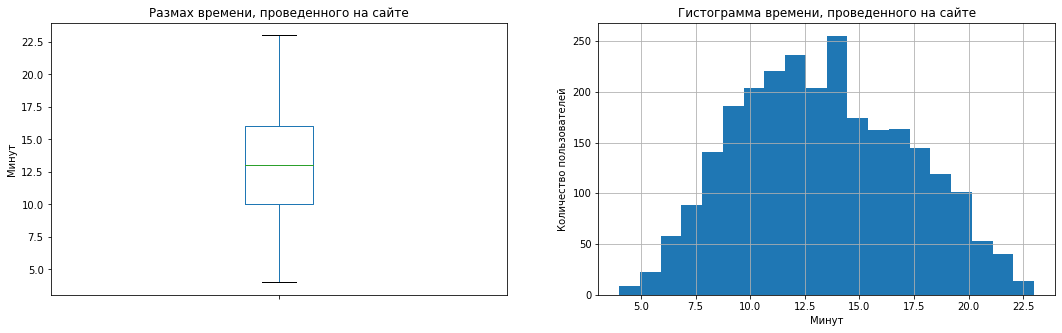

count   2,594.00
mean       13.34
std         4.08
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: minute, dtype: float64

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_time['minute'], 'Размах времени, проведенного на сайте', 'Минут', ax1, False)
show_hist(data_time['minute'], 20, 'Гистограмма времени, проведенного на сайте', 'Минут', 'Количество пользователей', ax2, False)
plt.show()

data_time['minute'].describe()

- Среднее значение проводимого времени - 13 минут
- Минимальное время: 4 минуты, максимальное: 23 минуты
- 50% пользователей проводят на сайте от 10 до 16 минут

### Данные среднемесячной прибыли за 3 месяца

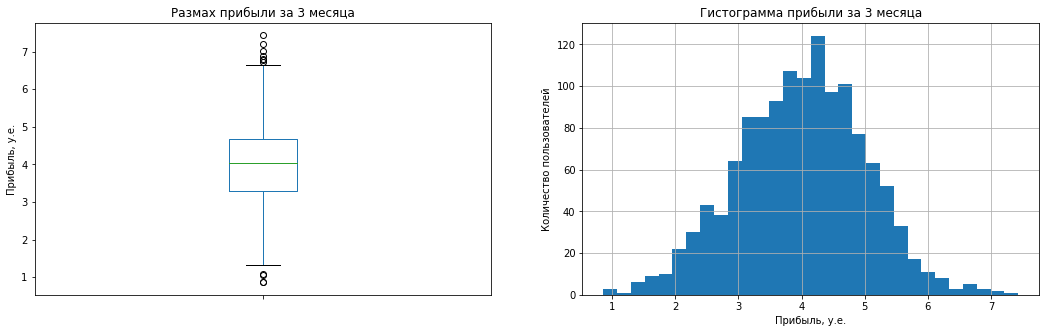

count   1,297.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: income_3_m, dtype: float64

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

show_boxplot(data_income['income_3_m'], 'Размах прибыли за 3 месяца', 'Прибыль, у.е.', ax1, False)
show_hist(data_income['income_3_m'], 30, 'Гистограмма прибыли за 3 месяца', 'Прибыль, у.е.', 'Количество пользователей', ax2, False)
plt.show()

data_income['income_3_m'].describe()

- Минимальной среднемесячной прибылью является значение в 0.86 у.е.
- Максимальное значение - 7.43 у.е.
- 50% пользователей среднемесячно приносят 3.3-4.7 у.е. прибыли
- Есть редкие значения в окрестности 1 и свыше 6.5 у.е

### Итог исследовательского анализа

Мы проанализировали пользователей, у которых последние три месяца была потребительская активность:

- 61.8% помечены как пользователи с прежним уровнем активности. Только у примерно трети пользователей (38.2%) уровень активности снизился

**Коммуникации с клиентом**
- 71.1% имеют стандартный статус, остальные 28.9% - премиум
- большая часть пользователей согласна на рассылки: 74%
- среднемесячное количество коммуникаций, получаемых пользователями за 6 месяцев 
    - в среднем: 4.3
    - половина пользователей получает от 3.7 до 4.9 коммуникаций
    - 36 пользователям направляется аномально мало коммуникаций - от 0.9 до 1.7
- Количество коммуникаций в текущем месяце:
    - 51.6% получили 4 коммуникации
    - Оставшиеся пользователи поделились на две практическо равные группы
        - 3 коммуникации (23.7%)
        - 5 коммуникаций (24.7%)
- Длительность истории с клиентом
    - Диапазон возможных значений составляет от 121 до 1079 дней (3 года)
    - В среднем длительность составляет 607 дней (чуть больше полутора лет)
    - 50% пользователей со "стажем" от 410 до 806 дней
    - Наблюдаются 
        - тенденция в уменьшении регистраций (600 дней и ранее)
        - всплески количества регистраций в это время, возможно, из-за проводимых рекламных компаний

**Продуктовое поведение**
- Среднемесячная доля покупок акционных товаров за 6 месяцев
    - 75% пользователей имеют долю акционный товаров до 30%
    - Среднее значение равно 24%
    - 168 пользователей имеют долю от 50 до 100% 
    - Минимальное значение доли - 11%
- Наиболее частая категория продукта в заказе
    - Самой популярной категорией является "Товары для детей" - четверть пользователей закупается преимущественно в ней (25.4%)
    - Тройку лидеров замыкают
        - Домашний текстиль 19.3%
        - Косметика и аксесуары 17.2%
    - Остальные категории увлекают менее половины пользователей (38.2%):
        - Техника для красоты и здоровья 14.1%
        - Мелкая бытовая техника и электроника 13.4%
        - Кухонная посуда 10.7%
- Среднее число просматриваемых категорий прозуктов за визит
    - Большая часть пользователей просматривает от 2 до 4 категорий (71.7%)
        - две 24.1%
        - три 27.4%
        - четыре 20.2%
    - Достаточно редко просматривают 6 категорий (6.6%) или 1 категорию (8.2%)
    - Пять категорий в среднем рассматривают 13.7%
- Число неоплаченных продуктов в корзине за последние 3 месяца
    - 50% пользователей имеет от 1 до 4 неоплаченных товаров
    - В среднем у пользователей 3 неоплаченных товара
    - Есть те, кто не оставляет товары в корзине - значение 0
    - 34 пользователя с аномально редким количеством товаров: от 8 до 10 штук

**Поведение на сайте**
- Количество сбоев сайта за последние 3 месяца 
    - 50% пользователей встречало от 3 до 6 сбоев
    - В среднем было 4 сбоя на пользователя
    - Есть пользователи, которых не затронули сбои (0)
    - Максимальное возможное число сбоев - 9
- Среднее число просматриваемых страниц за один визит на сайт за последние 3 месяца
    - 50% пользователей просматривают от 5 до 11 страниц за визит
    - В среднем пользователи просматривают 8 страницы за визит
    - Большой пласт пользователей просматривают от 11 до 20 страниц за визит
    - Единицы просматривают от 17 до 20 страниц или от 1 до 2 страниц
- Проводимое на сайте время за период
    - 50% пользователей проводят на сайте от 10 до 16 минут
    - Среднее значение проводимого времени - 13 минут
    - Минимальное время: 4 минуты, максимальное: 23 минуты

**Финансовое поведение**
- Сумма выручки за период
    - Половина пользователей (50%) приносят от 4 592 до 7 799 у.е. выручки за период
    - Среднее и медиана составляет 5 тыс. у.е.
- Среднемесячная прибыль от продаж каждому покупателю за последние 3 месяца
    - 50% пользователей среднемесячно приносят 3.3-4.7 у.е. прибыли
    - Минимальной среднемесячной прибылью является значение в 0.86 у.е.
    - Максимальное значение - 7.43 у.е.
    - Есть редкие значения в окрестности 1 и свыше 6.5 у.е

## Объединение таблиц

Для дальнейшей работы необходимо объединить данные о пользователях в одну таблицу. Объединим все данные, кроме данные о среднемесячной прибыли.

Информацию о выручке и времени нахождения на сайте присоединим таким образом, чтобы значение по каждому периоду было отдельной колонкой

Для начала выделим группы периодов в датафреймах выручки и времени проводимого на сайте

In [82]:
data_time_period = data_time.pivot_table(index='id', columns='period', values='minute')
data_time_period.head(5)

period,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10


In [83]:
data_money_period = data_money.pivot_table(index='id', columns='period', values='revenue')
data_money_period.head(5)

period,предпредыдущий_месяц,предыдущий_месяц,текущий_месяц
id,,,
215349,"4,472.00","5,216.00","4,971.60"
215350,"4,826.00","5,457.50","5,058.40"
215351,"4,793.00","6,158.00","6,610.40"
215352,"4,594.00","5,807.50","5,872.50"
215353,"5,124.00","4,738.50","5,388.50"


Переименуем колонки

In [84]:
data_time_period.columns = ['minute_prev_period', 'minute_cur_period']
data_time_period.head(1)

,minute_prev_period,minute_cur_period
id,,
215349,12,10


In [85]:
data_money_period.columns = ['revenue_before_prev_period', 'revenue_prev_period', 'revenue_cur_period']
data_money_period.head(1)

,revenue_before_prev_period,revenue_prev_period,revenue_cur_period
id,,,
215349,"4,472.00","5,216.00","4,971.60"


Объединим данные трех таблиц

In [86]:
data_full = data_main.copy()
data_full = data_full.merge(data_time_period, on='id').merge(data_money_period, on='id')
data_full.head(5)

,id,purchaser_activity,service_type,allow_notify,average_market_activ_6_m,market_activ_cur_m,duration_days,promo_purchases_6_m_per,popular_category_6_m,average_view_category_by_visit_cur_m,count_unpaid_product_basket_3_m,count_crash_3_m,average_view_page_by_visit_3_m,minute_prev_period,minute_cur_period,revenue_before_prev_period,revenue_prev_period,revenue_cur_period
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,12,10,"4,472.00","5,216.00","4,971.60"
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,"4,826.00","5,457.50","5,058.40"
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,11,13,"4,793.00","6,158.00","6,610.40"
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,8,11,"4,594.00","5,807.50","5,872.50"
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,"5,124.00","4,738.50","5,388.50"


По пяти строкам видно, что данные объединились корреткно.
<br>Проверим, что количество записей итогового датафрейма совпадает с первоначальным 

In [87]:
data_full.shape[0] == data_main.shape[0]

True

Убедимся, что типы данных новых колонок верны и нет явных пропусков

In [88]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1297 non-null   int64  
 1   purchaser_activity                    1297 non-null   object 
 2   service_type                          1297 non-null   object 
 3   allow_notify                          1297 non-null   object 
 4   average_market_activ_6_m              1297 non-null   float64
 5   market_activ_cur_m                    1297 non-null   int64  
 6   duration_days                         1297 non-null   int64  
 7   promo_purchases_6_m_per               1297 non-null   float64
 8   popular_category_6_m                  1297 non-null   object 
 9   average_view_category_by_visit_cur_m  1297 non-null   int64  
 10  count_unpaid_product_basket_3_m       1297 non-null   int64  
 11  count_crash_3_m  

Объединение прошло успешно: имеем итоговую таблицу со всеми данными о пользователях

Проведем дополнительно исследование новых колонок

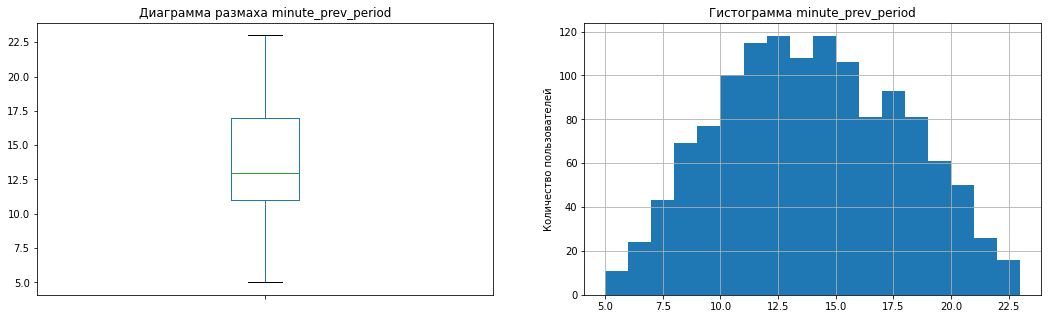

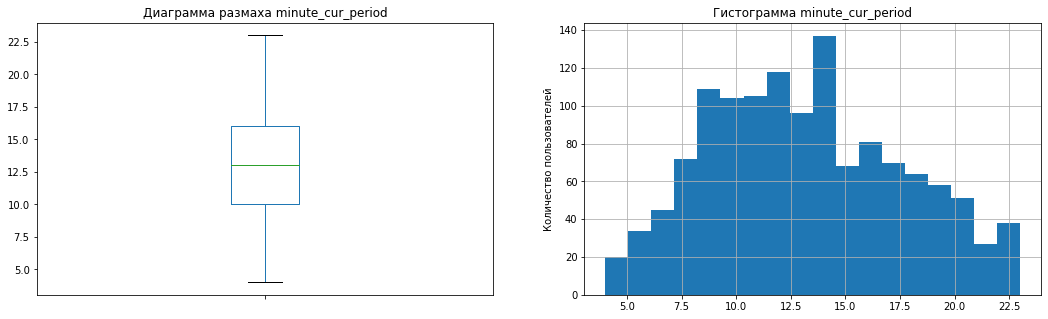

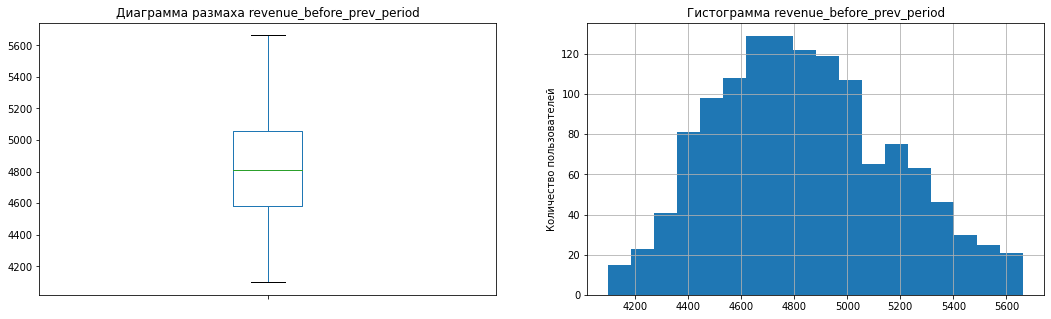

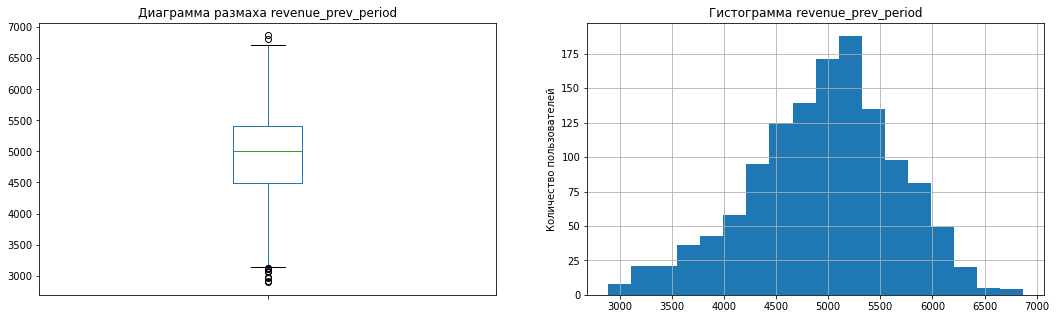

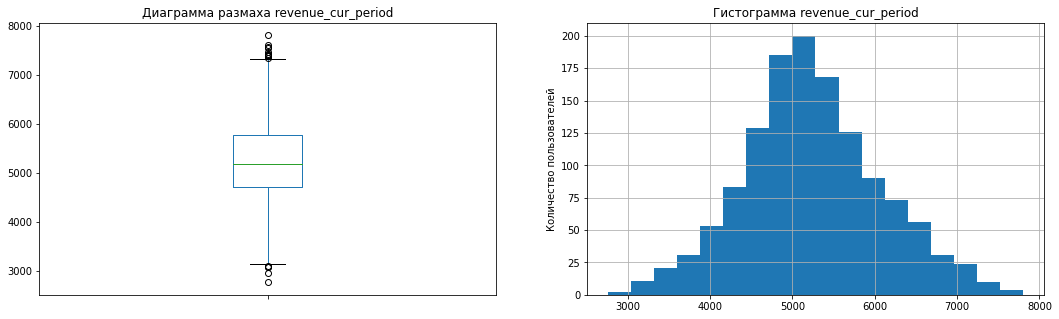

In [89]:
new_columns = [
    'minute_prev_period', 'minute_cur_period', 
    'revenue_before_prev_period', 'revenue_prev_period', 'revenue_cur_period'
]

for col in new_columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    show_boxplot(data_full[col], f'Диаграмма размаха {col}', '', ax1, False)
    show_hist(data_full[col], 18, f'Гистограмма {col}', '', 
              'Количество пользователей', ax2, False)
    plt.show()

Распределение у всех напоминает нормальное, у значений выручки за текущий и предыдущий периоды наблюдаются выбросы

## Корреляционный анализ

Изучим взаимосвязь между признаками - построим матрику корреляции и визуализируем ее

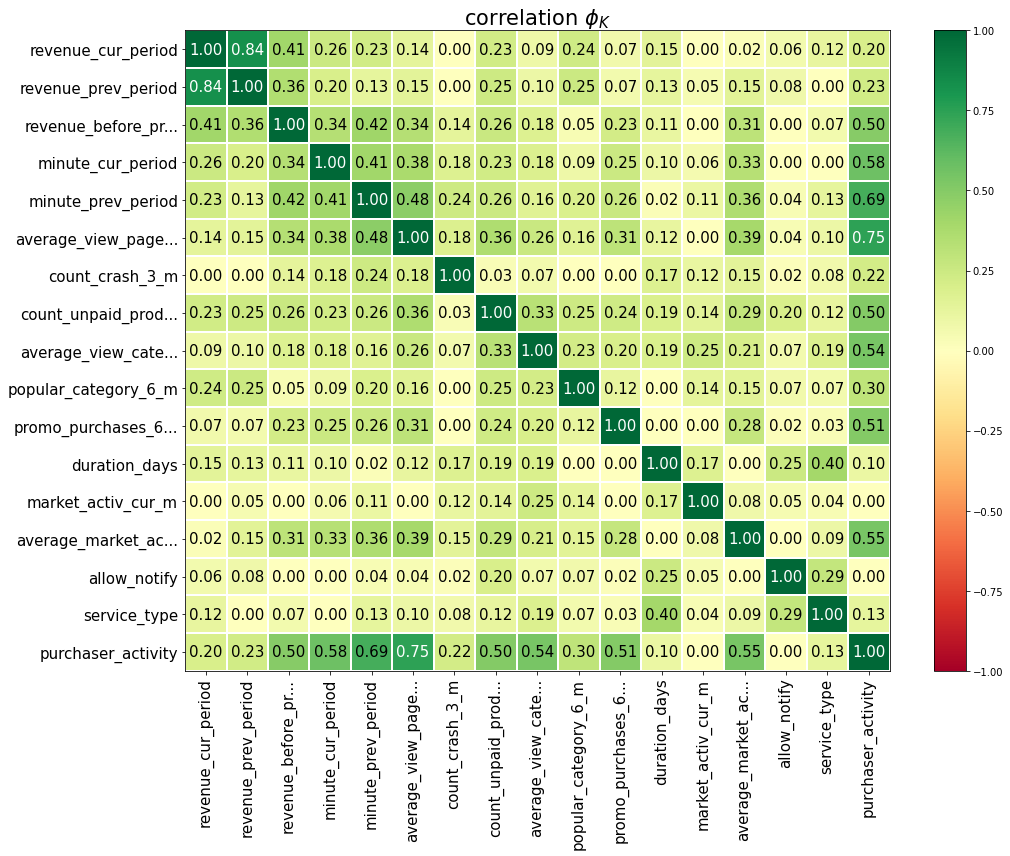

In [90]:
data_phik = data_full.loc[:, data_full.columns != 'id']

interval_cols = data_phik.select_dtypes(include='number').columns

phik_overview = data_phik.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

По тепловой карте можно сделать следующие выводы:
- 0.7-0.9: Высокая взаимосвязь между 
    - 0.84: `выручка в текущем периоде` и `выручка в предыдущем периоде`
    - 0.75: `тип активности` и `среднее кол-во просматриваемых страниц за визит за 3 месяца`
- 0.5-0.7: Сильная взаимосвязь между `тип активности` и
    - `минут на сайте в предыдущем периоде`
    - `минут на сайте в предпредыдущем периоде`
    - `среднемесячное кол-во коммуникаций за 6 месяцев`
    - `среднее кол-во категорий, просматриваемых за визит в текущем месяце`
    - `среднемесячная доля покупок по акции за 6 месяцев`
    - `кол-во неоплаченных товаров в корзине за 3 месяца`
    - `выручка в предпредыдущем периоде`
- У остальных пар признаков взаимосвязь умеренная или отсутствует вовсе

Наибольшей корреляцией в данных является значение 0.84 - оно указывает на высокую связь, но не критическую для мультиколлинеарности (значения > 0.9). Поэтому оставляем данные как есть

Дополнительно оценим вид связи между парой с максимальным коэффициентом

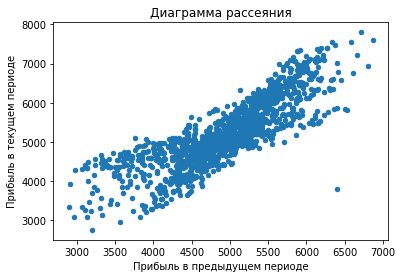

In [91]:
data_phik.plot(x='revenue_prev_period', y='revenue_cur_period', kind='scatter')
plt.title('Диаграмма рассеяния')
plt.xlabel('Прибыль в предыдущем периоде')
plt.ylabel('Прибыль в текущем периоде')
plt.show()

Диаграмма показывает практически линейную взаимосвязь с увеличением разброса в крайних значениях диапазона: в среднем с ростом прибыли в предыдущем периоде - растет и прибыль в текущем 

## Использование пайплайнов

Перейдем к обучению моделей. С помощью пайплайнов выполним подготовку данных и найдем лучшую модель.

В качестве метрики будем использовать **ROC AUC**:
- перед нами стоит задача бинарной классификации
- нас интересует вероятность, а не класс
- подходит при дисбалансе классов (соотношение классов целевого признака 4:6)

Для начала трансформируем датафрейм для обучения: удалим колонку id и закодируем значения целевого признака: отметим класс "Снизилась" как 1 — целевое негативное событие

In [92]:
data_train = data_full.copy().drop(['id'], axis=1)
data_train['purchaser_activity'] = data_train['purchaser_activity'].apply(lambda x: 1 if x == 'Снизилась' else 0)
data_train.head(2)

,purchaser_activity,service_type,allow_notify,average_market_activ_6_m,market_activ_cur_m,duration_days,promo_purchases_6_m_per,popular_category_6_m,average_view_category_by_visit_cur_m,count_unpaid_product_basket_3_m,count_crash_3_m,average_view_page_by_visit_3_m,minute_prev_period,minute_cur_period,revenue_before_prev_period,revenue_prev_period,revenue_cur_period
0,1,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,12,10,"4,472.00","5,216.00","4,971.60"
1,1,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,"4,826.00","5,457.50","5,058.40"


Создадим списки наименования колонок, разделив по виду последующей трансформации:
- категориальные:
    - для OHE
    - для OrdinalEncoder
- количественные
    - значения с выбросами (на основе диаграмм размаха)
    - остальные

In [93]:
y_column_name = 'purchaser_activity'

ohe_columns = ['allow_notify', 'popular_category_6_m']
ord_columns = ['service_type']

num_robust_columns = [
    'average_market_activ_6_m', 'promo_purchases_6_m_per', 'count_unpaid_product_basket_3_m', 
    'revenue_prev_period', 'revenue_cur_period'
]
num_std_columns = [
    'market_activ_cur_m', 'duration_days', 'average_view_category_by_visit_cur_m', 'count_crash_3_m', 
    'average_view_page_by_visit_3_m', 'minute_prev_period', 'minute_cur_period', 'revenue_before_prev_period'
]

Выделим целевой признак и входные параметры, и разобьем данные на тренировочную и тестовую выборки

In [94]:
X = data_train.drop([y_column_name], axis=1)
y = data_train[y_column_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    # присутствуется дисбаланс
    stratify = y 
)

Соберем пайплайн для подготовки данных

In [95]:
data_preprocessor = ColumnTransformer(
    [
        ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_columns),
        ('cat_ord', OrdinalEncoder(categories=[['стандарт', 'премиум']]), ord_columns),
        ('num_std', StandardScaler(), num_std_columns),
        ('num_robust', RobustScaler(), num_robust_columns),
    ], 
    remainder='passthrough'
)

Соберем итоговый пайплайн для обучения - будет включать в себя этап подготовки данных и обучения модели (укажем пока что DecisionTreeClassifier)

In [96]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor), 
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Поиск лучшей модели будем производить с помощью `GridSearchCV`:
- соберем параметры настроек для моделей (включая настройки гиперпараметров)
- инициализируем класс для поиска гиперпараметров на основе итогового пайплайна и параметров настроек 

In [97]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],
    }
]

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

Найдем лучшие параметры для задачи

In [98]:
grid_search.fit(X_train, y_train)
print('Лучшие параметры:', grid_search.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшие параметры: {'models': SVC(C=1, probability=True, random_state=42), 'models__C': 1}
Метрика лучшей модели на тренировочной выборке: 0.9134022088203906


Лучшим вариантом для тренировочной выборки оказалась модель `SVC` с ядром `rbf` (по умолчанию) и параметорм `C=1`, метрика составила 0.913

Проверим работу модели на тестовой выборке

In [99]:
y_test_pred = grid_search.predict_proba(X_test)[:,1]
print(f'Метрика на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика на тестовой выборке: 0.9192745947680949


Метрика 0.919, что свидетельствует о хорошей работе модели

## Анализ важности признаков

На основе лучшей модели построим графики SHAP и оценим важность признаков

Для этого:
- подготовим данные 
- выделим названия признаков
- построим график

### Подготовка

**Подготовка данных**

In [100]:
pipe = grid_search.best_estimator_

best_model = pipe.named_steps['models']
best_preprocessor = pipe.named_steps['preprocessor']

X_train_prep = best_preprocessor.transform(X_train)
X_test_prep = best_preprocessor.transform(X_test)

**Сбор наименования признаков**

In [101]:
ohe = best_preprocessor.named_transformers_['cat_ohe']
ohe_feature_names = ohe.get_feature_names(ohe_columns)
ord_feature_names = ord_columns
std_feature_names = num_std_columns
robust_feature_names = num_robust_columns

# Итоговый список собираем в том же порядке, что и в ColumnTransformer
# Дополнительно ограничиваем длину названия
feature_names = [name[:30] for name in (
    list(ohe_feature_names) + 
    ord_feature_names +
    std_feature_names +
    robust_feature_names
)]

### Построение графика

Создадим explainer

In [102]:
explainer = shap.Explainer(best_model.predict_proba, X_train_prep)

Получим значения Шепли

In [103]:
shap_values = explainer(X_test_prep)

PermutationExplainer explainer: 326it [04:06,  1.29it/s]                         


Построим графики по полученным значениям

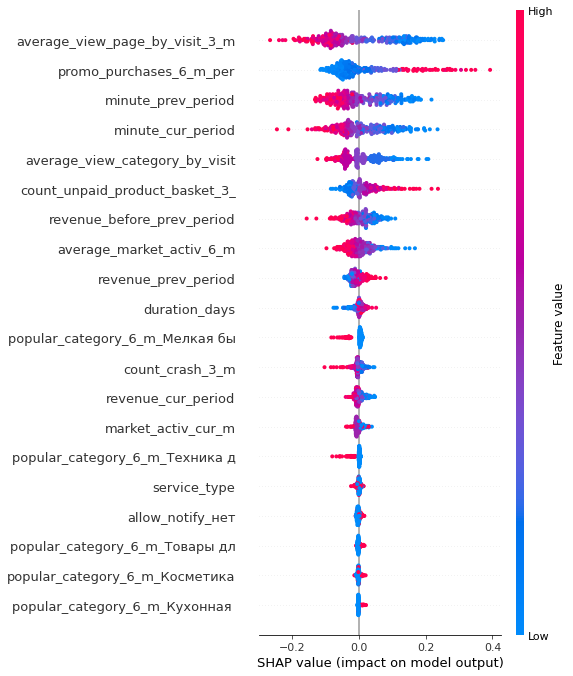

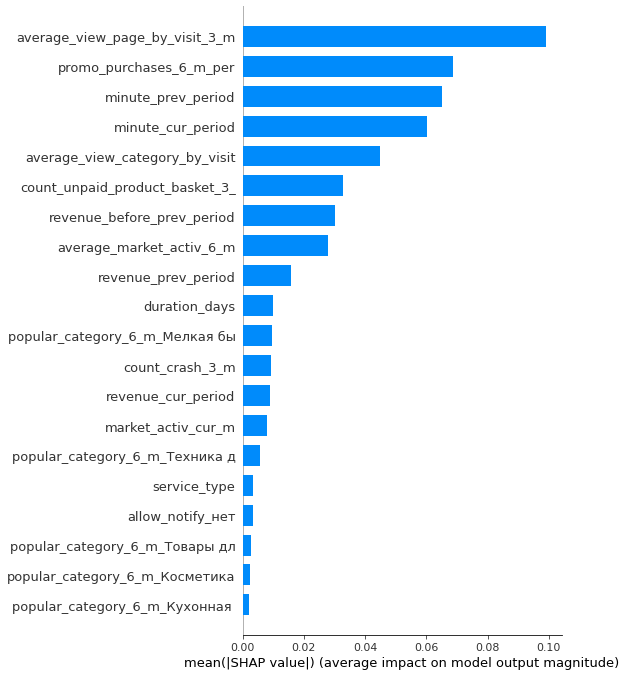

In [104]:
shap.summary_plot(shap_values[..., 1], X_test_prep, feature_names=feature_names, max_display=100)
shap.summary_plot(shap_values[..., 1], X_test_prep, feature_names=feature_names, max_display=100, plot_type="bar")

### Анализ важности

**Анализ графиков**

По графикам видно, что самые важные признаки:
- среднее число просмотренных страниц за визит (3 мес)
- доля промо-покупок (6 мес)
- время проведенное на сайте в предыдущем периоде (мин)
- время проведенное на сайте в текущем периоде (мин)
- среднее количество просматриваемых категорий за визит (текущий мес)

Модель чаще всего опирается именно на них при прогнозе "снизится ли активность", влияние от этих признаков наиболее значимо

Слабее влияют:
- количество неоплаченных товаров в корзине (3 мес)
- прибыль в предпредыдущем периоде
- среднемесячное количество коммуникаций (6 мес)

От остальных признаков ответ практически не зависит

**Выводы**

Повышают риск снижения активности следующие маркеры поведения:
- низкая пользовательская активность на сайте (мало просмотров страниц за визит)
- высокая доля покупок акционных товаров
- низкий показатель времени проводимого на сайте за текущий, предыдущий периоды
- малое количество категорий, просматриваемых за визит

А так же в меньшей степени:
- много неоплаченных товаров в корзине
- низкие значения прибыли в предпредыдущем периоде
- малое значение среднемесячных коммуникаций

Опираясь на эти результаты можно выстраивать бизнес-стратегию по предотвращению снижения активности

## Сегментация покупателей

### Выделим сегмент

Выделим сегмент покупателей с высоким риском снижения активности и высокой прибылью. 

Для этого построим график рассеивания

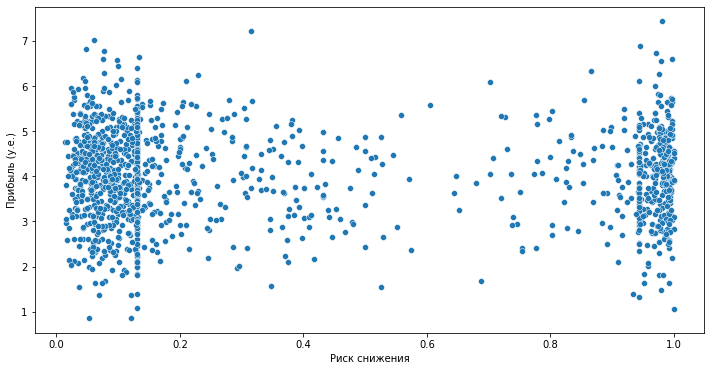

In [105]:
# Рассчитаем предсказание пробы
full_proba = pipe.predict_proba(data_full.drop(['id', 'purchaser_activity'], axis=1))[:, 1]

# Добавим результат в общую таблицу
data_full_result = data_full.copy()
data_full_result['risk'] = full_proba

# Добавим информацию о прибыли в общую таблицу
data_full_result = data_full_result.merge(data_income, on='id')

plt.figure(figsize=(12,6))
sns.scatterplot(data=data_full_result, x='risk', y='income_3_m')
plt.xlabel('Риск снижения')
plt.ylabel('Прибыль (у.е.)')
plt.show()

Видно, что риск преимущественно сосредоточен в диапазонах (0, 0.2) и (0.9, 1), промежуточные значения редки и хаотичны. 
<br>Порогом высокого риска примем значение 0.9

Что насчет прибыли: плотные скопления начинаются от ~3 у.е - положим это границей для сегментации

Выделим искомый сегмент и отметим его на диаграмме рассеивания

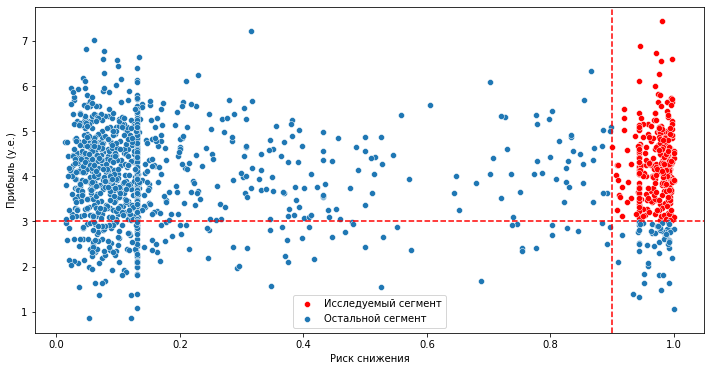

In [106]:
data_segment = data_full_result.query('risk >= 0.9 and income_3_m >= 3')
ids = list(data_segment['id'])
data_other = data_full_result.query('id not in @ids')

plt.figure(figsize=(12,6))
sns.scatterplot(data=data_segment, x='risk', y='income_3_m', label='Исследуемый сегмент', color='r')
sns.scatterplot(data=data_other, x='risk', y='income_3_m', label='Остальной сегмент')
plt.axvline(x=0.9, color='r', linestyle='--')
plt.axhline(y=3, color='r', linestyle='--')
plt.xlabel('Риск снижения')
plt.ylabel('Прибыль (у.е.)')
plt.show()

### Выберем группу пользователей

Выделим группу покупателей, с максимальной долей промо-товаров

Для выбора уровня доли - вспомним распределение данных

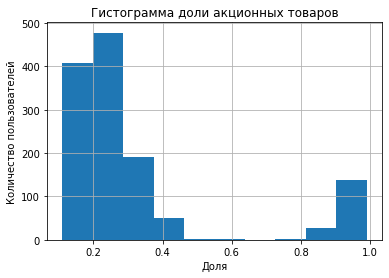

In [107]:
show_hist(data_full['promo_purchases_6_m_per'], 10, 'Гистограмма доли акционных товаров', 'Доля', 'Количество пользователей');

Отберем пользователей с долей выше 0.8 и посмотрим встречающиеся значения

In [108]:
data_full.query('promo_purchases_6_m_per > 0.6')['promo_purchases_6_m_per'].value_counts()

0.94    43
0.99    30
0.95    24
0.93    19
0.98    17
0.89    16
0.90    11
0.91     5
0.74     1
0.75     1
Name: promo_purchases_6_m_per, dtype: int64

Основной вклад на гистограмме начинается со значений 0.89 - положим его за порог

In [109]:
data_segment_promo = data_segment.query('promo_purchases_6_m_per >= 0.89')
print(f'Отобрано пользователей: {len(data_segment_promo)}')
data_segment_promo.head()

Отобрано пользователей: 92


,id,purchaser_activity,service_type,allow_notify,average_market_activ_6_m,market_activ_cur_m,duration_days,promo_purchases_6_m_per,popular_category_6_m,average_view_category_by_visit_cur_m,count_unpaid_product_basket_3_m,count_crash_3_m,average_view_page_by_visit_3_m,minute_prev_period,minute_cur_period,revenue_before_prev_period,revenue_prev_period,revenue_cur_period,risk,income_3_m
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,8,11,"4,594.00","5,807.50","5,872.50",0.97,4.21
14,215365,Снизилась,стандарт,да,3.90,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,6,10,"4,190.00","4,577.00","4,799.30",0.94,3.65
22,215373,Снизилась,премиум,нет,3.80,3,811,0.90,Товары для детей,2,5,5,3,10,8,"4,293.00","4,632.00","5,161.10",1.00,3.69
23,215374,Снизилась,стандарт,нет,2.90,5,268,0.98,Домашний текстиль,6,3,2,2,11,8,"4,666.00","5,762.50","5,720.90",0.94,4.08
24,215375,Снизилась,премиум,да,3.00,4,558,0.89,Товары для детей,3,3,7,4,8,9,"4,715.00","5,253.50","5,633.10",0.99,4.18


Получили группу в 92 пользователя

### Анализ группы

Проанализируем данные выделенной группы относительно остальных пользователей: для сравнения рассмотрим важные признаки по SHAP-анализу

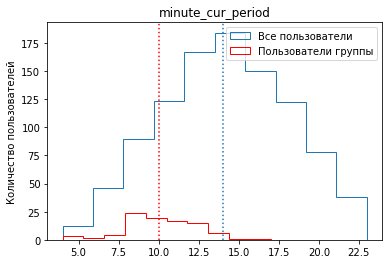

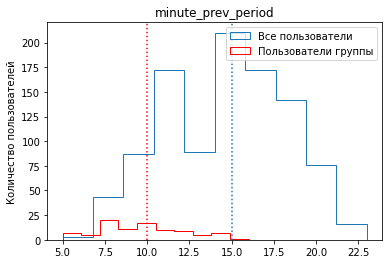

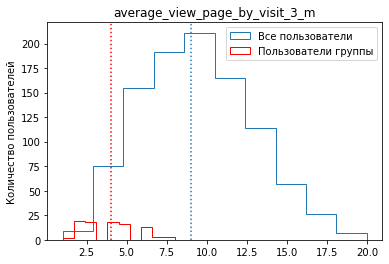

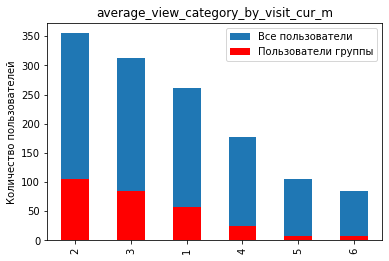

In [110]:
for col in ['minute_cur_period', 'minute_prev_period', 'average_view_page_by_visit_3_m']:
    first_data = data_other[col]
    second_data = data_segment_promo[col]
    
    ax1 = first_data.plot(kind='hist', histtype='step', legend=True, label='Все пользователи')
    ax1.axvline(x=first_data.median(), linestyle=':')
    
    
    ax2 = second_data.plot(ax=ax1, kind='hist', histtype='step', color='r', legend=True, label='Пользователи группы')
    ax2.axvline(x=second_data.median(), color='r', linestyle=':')
    
    plt.title(col)
    plt.ylabel('Количество пользователей')
    plt.show()
    
for col in ['average_view_category_by_visit_cur_m']:
    ax = data_full[col].value_counts().plot(kind='bar', legend=True, label='Все пользователи')
    data_segment[col].value_counts().plot(ax=ax, kind='bar', color='r', legend=True, label='Пользователи группы')
    plt.title(col)
    plt.ylabel('Количество пользователей')
    plt.show()

По данным графика можно отметить:
- пользователи провели относительно мало времени на сайте в текущем и предыдущем периодах: медианные значения (пунктирная линия) значительно ниже, чем у всех пользователей сайта
- среднее количество просмотренных сраниц пользователями на низком уровне, большинство из них тяготеет к минимальному времени нахождания на сайте
- в основном пользователи просматривают 2-3 категории

Все это указывает на то, что пользователям группы присуще поведение, которое может с высокой вероятностью сигнализировать о снижении активности.

Предложения для увеличения покупательской активности:
- расширять ассортимент категорий, участвующих в акциях
- ввести программу лояльности с накоплением баллов/скидок
- ввести персональные скидки
- собрать акционные товары по всем категориям на одной странице
- добавить механики ежедневной мотивации возвращаться на сайт (ежедневное колесо кешбека, категории недели, расписание акций) 

### Выводы

Мы построили сегмент пользователей, которые приносят ощутимую прибыль и имеют высокую вероятность к снижению активности - это приоритетные клиенты, на которых стоит обратить внимание бизнесу, чтобы минимизировать упущенную выгоду.

В этом сегменте рассмотрели тех пользователей, кто совершает много покупок по акции, что сильно влияет на вероятность снижения интереса. Проанализировали характиристики этих клиентов по другим важным параметрам из SHAP-анализа - заключили, что необходимо повышать время проводимое покупателями на сайте. Для данной группы это может быть введение активностей, направленных на получение выгоды (регулярные скидки, акции, программа лояльности) 

## Итоговый вывод

Мы провели работу по предсказанию снижения активности пользователей интернет-магазина

**Данные и предобработка**

Были использованы четыре таблицы с информацией о пользователях, их покупках, времени на сайте и прибыли.
Перед моделированием данные проверены: пропусков и дубликатов не было, в категориальных признаках исправлены единичные ошибки, числовые признаки проверены на выбросы (оставлены, поскольку отражают вероятные диапазоны значений). Составлена общая таблица с полными данными о пользователях

**Моделирование**

Данные подготовлены с использованием `ColumnTransformer`:
- категориальные признаки закодированы через `OneHotEncoder` и `OrdinalEncoder`
- числовые масштабированы через `StandardScaler` и `RobustScaler`

Для поиска лучшей модели 
- применили `GridSearchCV` с подбором гиперпараметров
- были рассмотрены модели: дерево решений, kNN, логистическая регрессия и SVC
- в качестве метрики выбрали ROC AUC так как стоит задача бинарной классификации с дисбалансом классов и важностью вероятностного прогноза.

Лучшая модель для задачи: SVC(rbf) с параметром C=1.
<br>Качество выбранной модели по метрике ROC AUC:
- 0.913 — на обучении
- 0.919 — на тесте

**Важность признаков**

SHAP-анализ показал, что наибольшее влияние оказывают:
- среднее число просмотренных страниц за визит
- доля промо-покупок
- время проведенное на сайте в текущем, предыдущем периодах
- среднее количество просматриваемых категорий за визит

Повышают риск снижения активности следующие маркеры поведения:
- низкая пользовательская активность на сайте
    - мало просмотров страниц за визит
    - низкий показатель времени проводимого на сайте
    - малое количество категорий, просматриваемых за визит
- высокая доля покупок акционных товаров

**Сегментация покупателей**

Рассмотрели сегмент пользователей с высокой прибылью и высокой вероятностью снижения покупательской активности, среди них выделили группу с высокой долей покупок товаров по акции

Выяснилось, что пользователям группы характерны все признаки, увеличивающие вероятность снижения интереса:
- минимальное время, проводимое на сайте
- малое просматриваемое количество страниц за визит
- низкий охват просматриваемых категорий

Предложения для бизнеса - удержать интерес покупателей
- расширять ассортимент категорий, участвующих в акциях
- ввести программу лояльности с накоплением баллов/скидок
- ввести персональные скидки
- собрать акционные товары по всем категориям на одной странице
- добавить механики ежедневной мотивации возвращаться на сайт (ежедневное колесо кешбека, категории недели, расписание акций) 

**Итоговые рекомендации** 
- стимулировать пользователей
    - проводить больше времени на сайте
    - просматривать больше категорий
- мотивировать совершать покупки не только товаров по акции
- не учитывать в продвигающих мероприятиях тип подписки и давность регистрации - эти данные совсем не влияют на уровень активности